# Глобин Дмитрий Алексеевич Б9122-01.03.02 мкт 
## Лабораторная работа №3
### MLP для нелинейно разделимых данных и задачи XOR

В этом ноутбуке:
1. Генерируем нелинейно разделимые данные (`make_moons`).
2. Визуализируем их на плоскости.
3. Реализуем MLP c архитектурой 2-4-1 (ReLU + выход без активации) на PyTorch.
4. Делим данные на обучающую и тестовую выборки (80/20).
5. Обучаем модель 1000 эпох, строим график потерь.
6. Оцениваем точность на тесте.
7. Отдельно обучаем MLP для решения классической задачи XOR (с перезапусками до полного решения).

## 1. Импорт библиотек
Все импорты собраны в одном блоке.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используем устройство:", device)

Используем устройство: cpu


## 2. Генерация нелинейно разделимых данных
Используем классический датасет `make_moons`, который заведомо нелинейно разделим.

In [2]:
n_samples = 1000

X, y = make_moons(
    n_samples=n_samples,
    noise=0.2,
    random_state=RANDOM_STATE
)

print("Форма X:", X.shape)  
print("Форма y:", y.shape) 

Форма X: (1000, 2)
Форма y: (1000,)


## 3. Визуализация данных на плоскости
Смотрим, как выглядят наши две «луны».

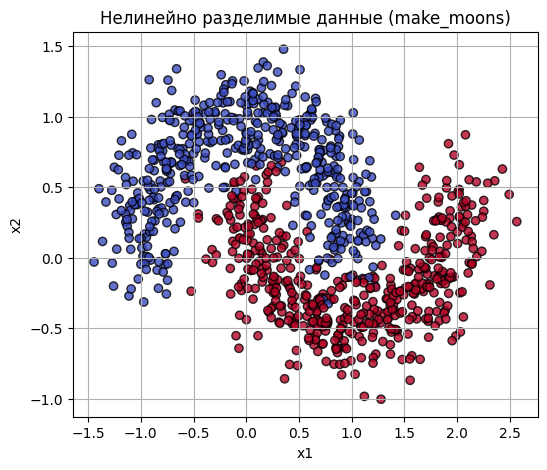

In [3]:
plt.figure(figsize=(6, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolor="k", alpha=0.8)
plt.title("Нелинейно разделимые данные (make_moons)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.show()

## 4. Разделение данных на обучение и тест
Разделяем выборку: 80% на обучение, 20% на тест. Затем превращаем всё в тензоры PyTorch.

In [4]:
# === 4. train / test split и подготовка данных ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Размер train:", X_train.shape, y_train.shape)
print("Размер test:", X_test.shape, y_test.shape)

# Преобразуем в тензоры PyTorch (float32, столбец для y)
X_train_t = torch.from_numpy(X_train.astype(np.float32)).to(device)
X_test_t  = torch.from_numpy(X_test.astype(np.float32)).to(device)

y_train_t = torch.from_numpy(y_train.astype(np.float32).reshape(-1, 1)).to(device)
y_test_t  = torch.from_numpy(y_test.astype(np.float32).reshape(-1, 1)).to(device)

Размер train: (800, 2) (800,)
Размер test: (200, 2) (200,)


## 5. Определение MLP 2-4-1 (выход без активации)
Архитектура по заданию: 2 входа, скрытый слой из 4 нейронов с ReLU и один выход.
На выходе **нет** сигмоиды, вместо этого используем `BCEWithLogitsLoss`,
которая сама внутри применяет сигмоиду и считает бинарную кросс-энтропию.

In [5]:
class MLP2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
        )

    def forward(self, x):
        return self.net(x)  
model = MLP2D().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print(model)

MLP2D(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=1, bias=True)
  )
)


## 6. Обучение модели (1000 эпох) и график потерь
Обучаем сеть на обучающей выборке и смотрим, как убывает функция потерь.

Эпоха  100/1000, loss = 0.3355
Эпоха  200/1000, loss = 0.3027
Эпоха  300/1000, loss = 0.2851
Эпоха  400/1000, loss = 0.2775
Эпоха  500/1000, loss = 0.2739
Эпоха  600/1000, loss = 0.2719
Эпоха  700/1000, loss = 0.2706
Эпоха  800/1000, loss = 0.2696
Эпоха  900/1000, loss = 0.2688
Эпоха 1000/1000, loss = 0.2679


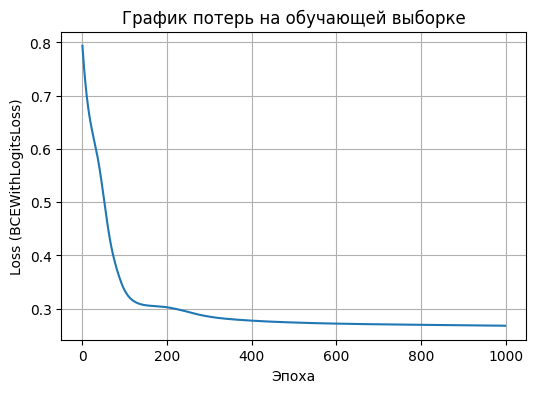

In [6]:
n_epochs = 1000
loss_history = []

for epoch in range(1, n_epochs + 1):
    model.train()
    optimizer.zero_grad()

    logits = model(X_train_t)
    loss = criterion(logits, y_train_t)

    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if epoch % 100 == 0:
        print(f"Эпоха {epoch:4d}/{n_epochs}, loss = {loss.item():.4f}")

plt.figure(figsize=(6, 4))
plt.plot(loss_history)
plt.xlabel("Эпоха")
plt.ylabel("Loss (BCEWithLogitsLoss)")
plt.title("График потерь на обучающей выборке")
plt.grid(True)
plt.show()

## 7. Оценка точности на обучении и тесте
Считаем долю правильно классифицированных объектов (accuracy) на train и test.

In [7]:
model.eval()
with torch.no_grad():

    train_logits = model(X_train_t)
    train_probs = torch.sigmoid(train_logits)
    y_train_pred = (train_probs >= 0.5).float()
    train_acc = (y_train_pred.eq(y_train_t).sum().item() / len(y_train_t))

    test_logits = model(X_test_t)
    test_probs = torch.sigmoid(test_logits)
    y_test_pred = (test_probs >= 0.5).float()
    test_acc = (y_test_pred.eq(y_test_t).sum().item() / len(y_test_t))

print(f"Точность на train: {train_acc:.3f}")
print(f"Точность на test:  {test_acc:.3f}")

Точность на train: 0.866
Точность на test:  0.950


## 8. MLP для решения задачи XOR
Теперь проверим ту же архитектуру MLP 2-4-1 на классической задаче XOR.
Чтобы избежать зависания в неудачной инициализации, будем несколько раз
переинициализировать сеть, пока она не выучит XOR (accuracy = 1.0 на 4 точках).


Пробуем обучить XOR, попытка 1/10
Accuracy на XOR после попытки 1: 0.750
Эта инициализация не идеально выучила XOR, пробуем ещё раз...

Пробуем обучить XOR, попытка 2/10
Accuracy на XOR после попытки 2: 1.000
Успех: сеть полностью выучила XOR.


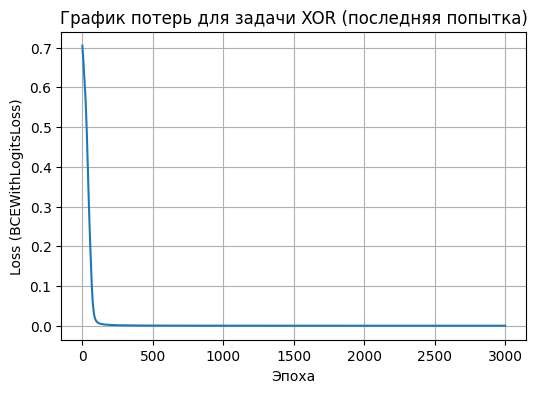

Входы:
[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]
Реальные метки:
[0. 1. 1. 0.]
Предсказанные вероятности:
[0. 1. 1. 0.]
Предсказанные классы:
[0 1 1 0]


In [8]:
X_xor = np.array([
    [0., 0.],
    [0., 1.],
    [1., 0.],
    [1., 1.]
], dtype=np.float32)

y_xor = np.array([
    [0.],
    [1.],
    [1.],
    [0.]
], dtype=np.float32)

X_xor_big = np.repeat(X_xor, 50, axis=0)
y_xor_big = np.repeat(y_xor, 50, axis=0)

X_xor_t = torch.from_numpy(X_xor_big).to(device)
y_xor_t = torch.from_numpy(y_xor_big).to(device)

max_attempts = 10
best_model = None
loss_history_xor = None

for attempt in range(1, max_attempts + 1):
    print(f"\nПробуем обучить XOR, попытка {attempt}/{max_attempts}")
    torch.manual_seed(RANDOM_STATE + attempt)
    xor_model = MLP2D().to(device)
    xor_criterion = nn.BCEWithLogitsLoss()
    xor_optimizer = torch.optim.Adam(xor_model.parameters(), lr=0.05)

    n_epochs_xor = 3000
    loss_history_xor = []

    for epoch in range(1, n_epochs_xor + 1):
        xor_model.train()
        xor_optimizer.zero_grad()

        logits_xor = xor_model(X_xor_t)
        loss_xor = xor_criterion(logits_xor, y_xor_t)

        loss_xor.backward()
        xor_optimizer.step()

        loss_history_xor.append(loss_xor.item())

    xor_model.eval()
    with torch.no_grad():
        X_xor_small_t = torch.from_numpy(X_xor).to(device)
        logits_small = xor_model(X_xor_small_t)
        probs_small = torch.sigmoid(logits_small)
        preds_small = (probs_small >= 0.5).float()

        y_true = torch.from_numpy(y_xor).to(device)
        correct = (preds_small.eq(y_true).sum().item())
        acc_xor = correct / 4.0

    print(f"Accuracy на XOR после попытки {attempt}: {acc_xor:.3f}")

    if acc_xor == 1.0:
        print("Успех: сеть полностью выучила XOR.")
        best_model = xor_model
        break
    else:
        print("Эта инициализация не идеально выучила XOR, пробуем ещё раз...")

if best_model is None:
    print("Предупреждение: ни одна из инициализаций не дала accuracy=1.0. Показываем последнюю модель.")
    best_model = xor_model

plt.figure(figsize=(6, 4))
plt.plot(loss_history_xor)
plt.xlabel("Эпоха")
plt.ylabel("Loss (BCEWithLogitsLoss)")
plt.title("График потерь для задачи XOR (последняя попытка)")
plt.grid(True)
plt.show()

best_model.eval()
with torch.no_grad():
    X_xor_small_t = torch.from_numpy(X_xor).to(device)
    logits_small = best_model(X_xor_small_t)
    probs_small = torch.sigmoid(logits_small)
    preds_small = (probs_small >= 0.5).float()

print("Входы:")
print(X_xor)
print("Реальные метки:")
print(y_xor.flatten())
print("Предсказанные вероятности:")
print(probs_small.cpu().numpy().round(3).flatten())
print("Предсказанные классы:")
print(preds_small.cpu().numpy().astype(int).flatten())